## Imports and Data Preprocessing

Import data and do basics of removing extraneous data

In [1]:
# Initial imports
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import np_utils

%matplotlib inline

In [2]:
# Import Verlander dataset 

verlander_df = pd.read_csv(Path("../resources/verlander_update.csv"),
                            index_col='game_date',
                            parse_dates=True,
                            infer_datetime_format=True)

display(verlander_df.head())

,pitch_type,player_name,batter,pitcher,events,description,zone,des,stand,p_throws,...,on_1b,outs_when_up,inning,at_bat_number,pitch_number,pitch_name,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
game_date,,,,,,,,,,,,,,,,,,,,,
2022-09-16,SL,"Verlander, Justin",669127,434378,strikeout,swinging_strike,9,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,5,Slider,0,2,Infield shift,Standard
2022-09-16,FF,"Verlander, Justin",669127,434378,NaN,foul,3,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,4,4-Seam Fastball,0,2,Infield shift,Standard
2022-09-16,SL,"Verlander, Justin",669127,434378,NaN,called_strike,13,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,3,Slider,0,2,Infield shift,Standard
2022-09-16,FF,"Verlander, Justin",669127,434378,NaN,foul,1,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,2,4-Seam Fastball,0,2,Infield shift,Standard
2022-09-16,SL,"Verlander, Justin",669127,434378,NaN,ball,8,Shea Langeliers strikes out swinging.,R,R,...,NaN,2,5,35,1,Slider,0,2,Infield shift,Standard


In [3]:
# Clean dataset 

verlander_df = verlander_df.drop(columns=['des', 
'pitch_name', 
'at_bat_number', 
'inning', 
'zone', 
'type', 
'player_name', 
'batter', 
'pitcher', 
'events',
'bb_type',
'hit_location',
'description',
'home_team',
'away_team'])

display(verlander_df.head())

,pitch_type,stand,p_throws,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
game_date,,,,,,,,,,,,,,
2022-09-16,SL,R,R,1,2,NaN,NaN,NaN,2,5,0,2,Infield shift,Standard
2022-09-16,FF,R,R,1,2,NaN,NaN,NaN,2,4,0,2,Infield shift,Standard
2022-09-16,SL,R,R,1,1,NaN,NaN,NaN,2,3,0,2,Infield shift,Standard
2022-09-16,FF,R,R,1,0,NaN,NaN,NaN,2,2,0,2,Infield shift,Standard
2022-09-16,SL,R,R,0,0,NaN,NaN,NaN,2,1,0,2,Infield shift,Standard


In [4]:
# Encode 1st, 2nd and 3rd bases with 1s and 0s

# Fill NaN to 0 
verlander_df['on_3b'] = verlander_df['on_3b'].fillna(0)
verlander_df['on_2b'] = verlander_df['on_2b'].fillna(0)
verlander_df['on_1b'] = verlander_df['on_1b'].fillna(0)

# Change batter IDs to 1 
verlander_df['on_3b'][verlander_df['on_3b'] > 0.0] = 1.0
verlander_df['on_2b'][verlander_df['on_2b'] > 0.0] = 1.0
verlander_df['on_1b'][verlander_df['on_1b'] > 0.0] = 1.0

display(verlander_df[1000:1050])

/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_2353/1265769177.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verlander_df['on_3b'][verlander_df['on_3b'] > 0.0] = 1.0
/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_2353/1265769177.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  verlander_df['on_2b'][verlander_df['on_2b'] > 0.0] = 1.0
/var/folders/zx/3xfmqcd54f3fdz2hfpnll0_80000gn/T/ipykernel_2353/1265769177.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

,pitch_type,stand,p_throws,balls,strikes,on_3b,on_2b,on_1b,outs_when_up,pitch_number,bat_score,fld_score,if_fielding_alignment,of_fielding_alignment
game_date,,,,,,,,,,,,,,
2022-06-29,FF,L,R,0,1,0.0,0.0,0.0,0,2,0,0,Standard,Standard
2022-06-29,FF,L,R,0,0,0.0,0.0,0.0,0,1,0,0,Standard,Standard
2022-06-29,CH,L,R,3,2,1.0,0.0,1.0,2,9,0,0,Standard,Standard
2022-06-29,FF,L,R,3,2,1.0,0.0,1.0,2,8,0,0,Standard,Standard
2022-06-29,SL,L,R,3,2,1.0,0.0,1.0,2,7,0,0,Standard,Standard
2022-06-29,FF,L,R,2,2,1.0,0.0,1.0,2,6,0,0,Standard,Standard
2022-06-29,FF,L,R,2,2,1.0,0.0,1.0,2,5,0,0,Standard,Standard
2022-06-29,FF,L,R,2,1,1.0,0.0,1.0,2,4,0,0,Standard,Standard
2022-06-29,FF,L,R,2,0,1.0,0.0,1.0,2,3,0,0,Standard,Standard


## Data Processing 

Prepare data to be fed into model

In [5]:
# Split into X and y 

X = verlander_df.drop(columns='pitch_type')
y= verlander_df['pitch_type']

In [6]:
# Use get_dummies to encode categorical variables 

X = pd.get_dummies(X)

#y = y.map({'CH': 1, 'CU': 2, 'FF': 3, 'SL': 4})

encoder = LabelEncoder()
encoder.fit(y)
encoded_y = encoder.transform(y)
# convert integers to dummy variables (i.e. one hot encoded)
dummy_y = np_utils.to_categorical(encoded_y)



#display(X.head())
display(dummy_y[30:50])
display(y[30:50])


# SL = index 3
# CH = index 0
# FF = index 2
# CU = index 1

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

game_date
2022-09-16    SL
2022-09-16    SL
2022-09-16    SL
2022-09-16    CH
2022-09-16    FF
2022-09-16    FF
2022-09-16    CU
2022-09-16    SL
2022-09-16    SL
2022-09-16    CH
2022-09-16    SL
2022-09-16    CU
2022-09-16    FF
2022-09-16    CU
2022-09-16    SL
2022-09-16    SL
2022-09-16    FF
2022-09-16    FF
2022-09-16    FF
2022-09-16    SL
Name: pitch_type, dtype: object

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, dummy_y, random_state=1)

## Deep Learning/Neural Network Architecture

Using the method from the module, the following basis is used to design the first iteration of the neural network: 

*the mean of the number of input features and the number of neurons in the output layer ((number of input features + number of neurons in output layer) / 2). Use a number close to this mean for the number of neurons in the first hidden layer. Repeat this pattern for subsequent hidden layers ((number of neurons in the prior hidden layer + number of neurons in output layer) / 2). Softmax is the activation for the output layer that is used for multi-class classification. Categorial cross entropy and predictive model accuracy are respectively the loss functions and metrics used for multi-class classification*

In [8]:
# Initialize the Deep Learning Neural Network model

nn_v0 = Sequential()

2022-09-25 17:51:19.398510: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Design the network architecture 

# Define the model - deep neural net
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v0.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v0.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v0.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v0.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

display(nn_v0.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                180       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
 dense_2 (Dense)             (None, 4)                 24        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


None

In [10]:
# Fit the data to the model

model_v0 = nn_v0.fit(X_train, y_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 893us/step - loss: 1.3821 - accuracy: 0.3670
Epoch 2/100
55/55 [==============================] - 0s 842us/step - loss: 1.2765 - accuracy: 0.5063
Epoch 3/100
55/55 [==============================] - 0s 785us/step - loss: 1.2208 - accuracy: 0.5068
Epoch 4/100
55/55 [==============================] - 0s 794us/step - loss: 1.1846 - accuracy: 0.5068
Epoch 5/100
55/55 [==============================] - 0s 770us/step - loss: 1.1592 - accuracy: 0.5068
Epoch 6/100
55/55 [==============================] - 0s 781us/step - loss: 1.1400 - accuracy: 0.5068
Epoch 7/100
55/55 [==============================] - 0s 824us/step - loss: 1.1222 - accuracy: 0.5068
Epoch 8/100
55/55 [==============================] - 0s 789us/step - loss: 1.1094 - accuracy: 0.5068
Epoch 9/100
55/55 [==============================] - 0s 803us/step - loss: 1.0977 - accuracy: 0.5068
Epoch 10/100
55/55 [==============================] - 0s 766us/step - loss: 1.0884 - accura

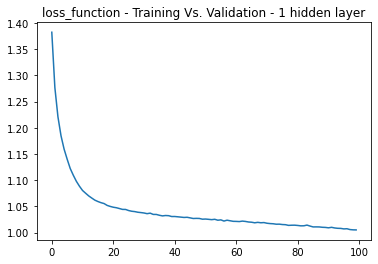

In [11]:
# Plot the loss over epochs

plt.plot(model_v0.history["loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
#plt.legend(["train", "test"])
plt.show()

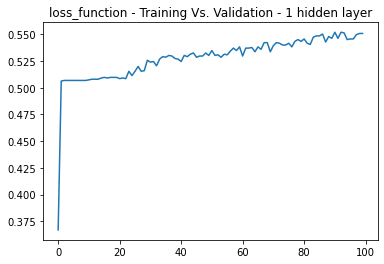

In [12]:
# Plot the accuracy over epochs

plt.plot(model_v0.history["accuracy"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
#plt.legend(["train", "test"])
plt.show()

In [13]:
model_loss, model_accuracy = nn_v0.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 1.0402 - accuracy: 0.4949 - 123ms/epoch - 6ms/step
Loss: 1.0402358770370483, Accuracy: 0.49486300349235535


In [14]:

y_pred = nn_v0.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results.head())
display(classification_report(final_results['Actual'], final_results['Predictions']))


19/19 [==============================] - 0s 615us/step


,Predictions,Actual
0,SL,FF
1,SL,FF
2,FF,FF
3,FF,FF
4,FF,CU


/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n          CH       0.00      0.00      0.00         8\n          CU       0.35      0.09      0.15       120\n          FF       0.55      0.74      0.63       292\n          SL       0.38      0.38      0.38       164\n\n    accuracy                           0.49       584\n   macro avg       0.32      0.30      0.29       584\nweighted avg       0.46      0.49      0.45       584\n'

## Optimize the Model

### Optimized Model 1
Optimize the model by increasing the number of epochs 

In [15]:
#Define the new, optimized model

nn_v1 = Sequential()

In [16]:
# Design the network architecture 

# Define the model - deep neural net
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v1.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v1.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v1.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

display(nn_v1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 10)                180       
                                                                 
 dense_4 (Dense)             (None, 5)                 55        
                                                                 
 dense_5 (Dense)             (None, 4)                 24        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


None

In [17]:
# Fit the data to the model

model_v1 = nn_v1.fit(X_train, y_train, epochs=500)

Epoch 1/500
55/55 [==============================] - 0s 863us/step - loss: 1.3548 - accuracy: 0.4247
Epoch 2/500
55/55 [==============================] - 0s 836us/step - loss: 1.2735 - accuracy: 0.4971
Epoch 3/500
55/55 [==============================] - 0s 860us/step - loss: 1.2287 - accuracy: 0.5057
Epoch 4/500
55/55 [==============================] - 0s 811us/step - loss: 1.1935 - accuracy: 0.5068
Epoch 5/500
55/55 [==============================] - 0s 838us/step - loss: 1.1642 - accuracy: 0.5068
Epoch 6/500
55/55 [==============================] - 0s 837us/step - loss: 1.1394 - accuracy: 0.5068
Epoch 7/500
55/55 [==============================] - 0s 781us/step - loss: 1.1193 - accuracy: 0.5068
Epoch 8/500
55/55 [==============================] - 0s 771us/step - loss: 1.1033 - accuracy: 0.5068
Epoch 9/500
55/55 [==============================] - 0s 786us/step - loss: 1.0928 - accuracy: 0.5068
Epoch 10/500
55/55 [==============================] - 0s 789us/step - loss: 1.0820 - accura

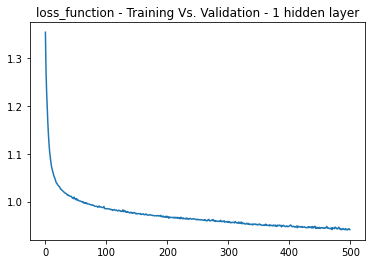

In [18]:
# Plot the loss over epochs

plt.plot(model_v1.history["loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
plt.show()

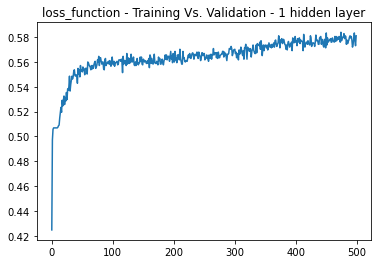

In [19]:
# Plot the accuracy over epochs

plt.plot(model_v1.history["accuracy"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
#plt.legend(["train", "test"])
plt.show()

In [20]:
model_loss, model_accuracy = nn_v1.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 1.1234 - accuracy: 0.4983 - 101ms/epoch - 5ms/step
Loss: 1.1233583688735962, Accuracy: 0.4982876777648926


In [21]:

y_pred = nn_v1.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results_v1 = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results_v1.head())
display(classification_report(final_results['Actual'], final_results['Predictions']))

19/19 [==============================] - 0s 641us/step


,Predictions,Actual
0,FF,FF
1,SL,FF
2,FF,FF
3,FF,FF
4,FF,CU


/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n          CH       0.00      0.00      0.00         8\n          CU       0.35      0.09      0.15       120\n          FF       0.55      0.74      0.63       292\n          SL       0.38      0.38      0.38       164\n\n    accuracy                           0.49       584\n   macro avg       0.32      0.30      0.29       584\nweighted avg       0.46      0.49      0.45       584\n'

### Optimized Model 2

From Keras, use the stochastic gradient descent (SGD) optimizer that is an iterative method for optimizing an objective function with suitable smoothness properties

In [22]:
# Define the model

nn_v2 = Sequential()

In [23]:
# Design the network architecture 

import tensorflow as tf

tf.keras.optimizers.Adadelta(
    learning_rate=0.001,
    rho=0.95,
    epsilon=1e-07,
    name='Adadelta'
)
#from keras.optimizers import Adadelta
# Define the model - deep neural net

total_neurons = len(X.columns)*(2/3)
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v2.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v2.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v2.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v2.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

display(nn_v2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 10)                180       
                                                                 
 dense_7 (Dense)             (None, 5)                 55        
                                                                 
 dense_8 (Dense)             (None, 4)                 24        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


None

In [24]:
# Fit the data to the model

model_v2 = nn_v2.fit(X_train, y_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 849us/step - loss: 2.5543 - accuracy: 0.0274
Epoch 2/100
55/55 [==============================] - 0s 840us/step - loss: 2.5513 - accuracy: 0.0274
Epoch 3/100
55/55 [==============================] - 0s 811us/step - loss: 2.5482 - accuracy: 0.0274
Epoch 4/100
55/55 [==============================] - 0s 907us/step - loss: 2.5450 - accuracy: 0.0274
Epoch 5/100
55/55 [==============================] - 0s 926us/step - loss: 2.5418 - accuracy: 0.0274
Epoch 6/100
55/55 [==============================] - 0s 785us/step - loss: 2.5385 - accuracy: 0.0274
Epoch 7/100
55/55 [==============================] - 0s 860us/step - loss: 2.5352 - accuracy: 0.0274
Epoch 8/100
55/55 [==============================] - 0s 817us/step - loss: 2.5318 - accuracy: 0.0274
Epoch 9/100
55/55 [==============================] - 0s 822us/step - loss: 2.5284 - accuracy: 0.0274
Epoch 10/100
55/55 [==============================] - 0s 818us/step - loss: 2.5249 - accura

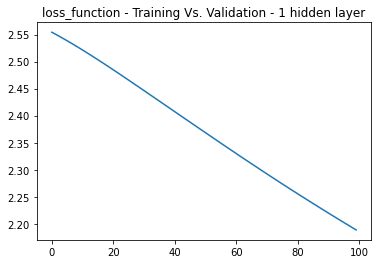

In [25]:
# Plot the loss over epochs

plt.plot(model_v2.history["loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
plt.show()

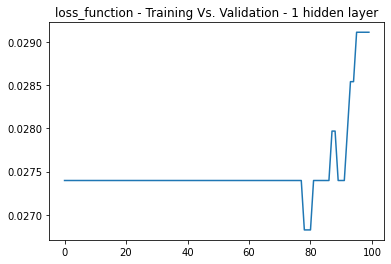

In [26]:
# Plot the accuracy over epochs

plt.plot(model_v2.history["accuracy"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
#plt.legend(["train", "test"])
plt.show()

In [27]:
model_loss, model_accuracy = nn_v2.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 2.2227 - accuracy: 0.0171 - 106ms/epoch - 6ms/step
Loss: 2.2227370738983154, Accuracy: 0.017123287543654442


In [28]:

y_pred = nn_v2.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results_v2 = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results_v2.head())
display(classification_report(final_results['Actual'], final_results['Predictions']))

19/19 [==============================] - 0s 841us/step


,Predictions,Actual
0,CH,FF
1,CH,FF
2,CH,FF
3,CH,FF
4,CH,CU


/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n          CH       0.00      0.00      0.00         8\n          CU       0.35      0.09      0.15       120\n          FF       0.55      0.74      0.63       292\n          SL       0.38      0.38      0.38       164\n\n    accuracy                           0.49       584\n   macro avg       0.32      0.30      0.29       584\nweighted avg       0.46      0.49      0.45       584\n'

### Optimized Model 3

From Keras, use the stochastic gradient descent (SGD) optimizer that is an iterative method for optimizing an objective function with suitable smoothness properties

In [32]:
# Define the model

nn_v3 = Sequential()

In [33]:
# Design the network architecture 


from keras.optimizers import SGD
# Define the model - deep neural net

total_neurons = len(X.columns)*(2/3)
number_input_features = len(X.columns)
number_output = 4

# Define hidden layers
i = 0
hidden_nodes_layer=(number_input_features+number_output)/2
while hidden_nodes_layer/2 > 4: 
    if i == 0:
        nn_v3.add(Dense(units=round(hidden_nodes_layer), input_dim=number_input_features, activation='relu'))
        i+=1
    else:
        hidden_nodes_layer = hidden_nodes_layer/2
        nn_v3.add(Dense(units=round(hidden_nodes_layer), activation='relu'))
        i+=1

# Define output layer
nn_v3.add(Dense(units=number_output, activation='softmax'))

# Compile the model
nn_v3.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

display(nn_v3.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 10)                180       
                                                                 
 dense_16 (Dense)            (None, 5)                 55        
                                                                 
 dense_17 (Dense)            (None, 4)                 24        
                                                                 
Total params: 259
Trainable params: 259
Non-trainable params: 0
_________________________________________________________________


None

In [34]:
# Fit the data to the model

model_v3 = nn_v3.fit(X_train, y_train, epochs=100)

Epoch 1/100
55/55 [==============================] - 0s 771us/step - loss: 1.3972 - accuracy: 0.3031
Epoch 2/100
55/55 [==============================] - 0s 913us/step - loss: 1.2952 - accuracy: 0.4275
Epoch 3/100
55/55 [==============================] - 0s 1ms/step - loss: 1.2444 - accuracy: 0.4686
Epoch 4/100
55/55 [==============================] - 0s 1ms/step - loss: 1.2079 - accuracy: 0.4977
Epoch 5/100
55/55 [==============================] - 0s 1ms/step - loss: 1.1805 - accuracy: 0.5011
Epoch 6/100
55/55 [==============================] - 0s 975us/step - loss: 1.1605 - accuracy: 0.4989
Epoch 7/100
55/55 [==============================] - 0s 919us/step - loss: 1.1462 - accuracy: 0.5080
Epoch 8/100
55/55 [==============================] - 0s 875us/step - loss: 1.1355 - accuracy: 0.5029
Epoch 9/100
55/55 [==============================] - 0s 734us/step - loss: 1.1278 - accuracy: 0.5046
Epoch 10/100
55/55 [==============================] - 0s 733us/step - loss: 1.1221 - accuracy: 0.

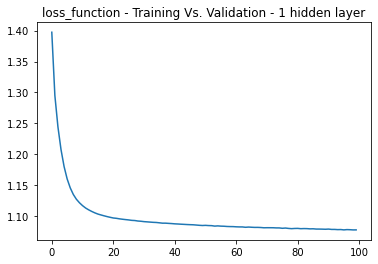

In [35]:
# Plot the loss over epochs

plt.plot(model_v3.history["loss"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
plt.show()

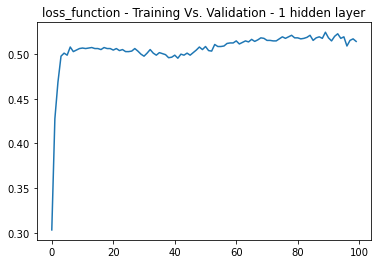

In [36]:
# Plot the accuracy over epochs

plt.plot(model_v3.history["accuracy"])
plt.title("loss_function - Training Vs. Validation - 1 hidden layer")
#plt.legend(["train", "test"])
plt.show()

In [37]:
model_loss, model_accuracy = nn_v3.evaluate(
    X_test, y_test, verbose=2
)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

19/19 - 0s - loss: 1.0712 - accuracy: 0.5051 - 108ms/epoch - 6ms/step
Loss: 1.0712165832519531, Accuracy: 0.5051369667053223


In [38]:

y_pred = nn_v3.predict(X_test)
pred_final = np.argmax(y_pred, axis=1)

y_test_reverted = []
for lists in y_test:
    if lists[0] == 1:
        y_test_reverted.append('CH')
    elif lists[1] == 1:
        y_test_reverted.append('CU')
    elif lists[2] == 1:
        y_test_reverted.append('FF')
    else:
        y_test_reverted.append('SL')

y_pred_converted = []
for numbers in pred_final:
    if numbers == 0:
        y_pred_converted.append('CH')
    elif numbers == 1:
        y_pred_converted.append('CU')
    elif numbers == 2:
        y_pred_converted.append('FF')
    else: 
        y_pred_converted.append('SL')

# display(y_test)
# display(pred_final)
final_results_v3 = pd.DataFrame({
    'Predictions': y_pred_converted,
    'Actual':  y_test_reverted})

display(final_results_v3.head())
display(classification_report(final_results['Actual'], final_results['Predictions']))

19/19 [==============================] - 0s 652us/step


,Predictions,Actual
0,FF,FF
1,SL,FF
2,FF,FF
3,FF,FF
4,FF,CU


/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/envs/dev/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


'              precision    recall  f1-score   support\n\n          CH       0.00      0.00      0.00         8\n          CU       0.35      0.09      0.15       120\n          FF       0.55      0.74      0.63       292\n          SL       0.38      0.38      0.38       164\n\n    accuracy                           0.49       584\n   macro avg       0.32      0.30      0.29       584\nweighted avg       0.46      0.49      0.45       584\n'